# SAT NETs for the 2024 "Pivot to Chile"

June 2024

This notebook calculates NETs for a variety of SAT configurations:
1) Old "pole baseline" and "AoA HWP w/ Scaled optics" designs used in 2022-3, for comparison sake.
2) New "max mapping speed" models that we are considering for use in Chile, and for comparison's sake, Pole.
3) "Aggr"essive models that (roughly) match SO's aggressiveness.

This modeling uses flat bands, and a single number for each band's spillover, estimated by scaling from the LAT-MF feedhorn given the relevant f/#.

NETs are calculated per detector, per wafer, and "per tube", where horn-horn correlations, yield, the number of wafers/tube and the optically good fraction of detectors in a tube are all taken into account.


In [1]:
!pwd

/Users/ruhl/code/bolo_calc_runs/jbolo/AoA/2024


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
from jbolo_funcs import *

%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
# List what yaml files you have so you can choose one for the next line.
!ls -lt1 yamls 

SAT_HWP_aggr_20240916.yaml
SAT_aggr_20240825.yaml
old
SAT_max_20240825.yaml
SAT_baseline_20240825.yaml
SAT_HWP_max_f145_20240825.yaml
SAT_HWP_max_20240825.yaml
SAT_HWP_aggr_20240825.yaml
SAT_HWP_AoAscaledoptics_20240825.yaml
Atacama-TMALAT_20240715.yaml
Atacama-CDLAT_20240715.yaml


In [4]:
# Dictionary of models to use, which includes yaml file for now, but will have results in it later.
SAT_models = {'Pole_orig':{},'Pole_max':{},'Chile_AoAAlt3':{},'Chile_max':{}}
SAT_models['Pole_orig']={  # Pole baseline
    'yaml':'SAT_baseline_20240825.yaml', # base yaml file to start with before mods
}

SAT_models['Pole_aggr']={  # Pole max mapping speed, no HWP
    'yaml':'SAT_aggr_20240825.yaml', 
}

SAT_models['Pole_max']={  # Pole max mapping speed, no HWP
    'yaml':'SAT_max_20240825.yaml', 
}

SAT_models['Chile_AoAAlt3']={  # Atacama AoA scaled optics
    'yaml':'SAT_HWP_AoAscaledoptics_20240825.yaml',
}

SAT_models['Chile_aggr']={  # Atacama "SO aggressiveness" w/ HWP
    'yaml':'SAT_HWP_aggr_20240916.yaml', #  Previous version had wrong spillovers
}

SAT_models['Chile_max']={  # Atacama "max mapping speed" w/ HWP
    'yaml':'SAT_HWP_max_20240825.yaml', # base yaml file to start with before mods.  
}

SAT_models['Chile_max_f145']={  # Atacama max mapping speed w/ larger HWP, such that we have same f/# as original pole baseline.
    'yaml':'SAT_HWP_max_f145_20240825.yaml', # base yaml file to start with before mods
}

We're going to do this a very simple way, where we explicitly run each sim and plot it before moving on to the next.


In [5]:
models = ['Pole_orig','Pole_aggr','Pole_max','Chile_AoAAlt3','Chile_aggr','Chile_max', 'Chile_max_f145']

sims={}
# Run each model
for model in models:
    # Set up
    yamlfile = 'yamls/'+SAT_models[model]['yaml']
    sim = yaml.safe_load(open(yamlfile))
    SAT_models[model]['comment'] = 'NETs are in uKrtsec; powers are in pW'
    SAT_models[model]['name'] = sim['version']['name']
    SAT_models[model]['date'] = sim['version']['date']
    SAT_models[model]['site'] = sim['sources']['atmosphere']['site']
    SAT_models[model]['pwv'] = sim['sources']['atmosphere']['pwv']
    SAT_models[model]['elev'] = sim['sources']['atmosphere']['elevation']
    SAT_models[model]['wafers'] = sim['bolo_config']['num_wafers_per_tube']
    SAT_models[model]['optically_good_fraction'] = sim['bolo_config']['optically_good_det_fraction']
    
    # Run
    run_optics(sim)
    run_bolos(sim)
 
    # Pack outputs into the models dictionary
    SAT_models[model]['channels']=sim['outputs'].keys()
    ii = 0
    for ch in SAT_models[model]['channels']:
        SAT_models[model][ch]={}
        net1det = 1e6*sim['outputs'][ch]['NET_C_total']  # use the version with horn-horn correlations
        ndet = sim['channels'][ch]['num_det_per_wafer']  # detectors per wafer
        net_wafer = net1det/np.sqrt(ndet*sim['bolo_config']['yield'])  #Take yield into account, usually 80%
        net_tube = net_wafer/np.sqrt(SAT_models[model]['wafers']*SAT_models[model]['optically_good_fraction'])  #Take yield into account, usually 80%
        ms = 1/net_tube**2
        SAT_models[model][ch]['P_sat'] = 1e12*sim['outputs'][ch]['P_sat']   #convert to pW from W
        SAT_models[model][ch]['NET_wafer'] = net_wafer   #convert to uKrtsec from Krtsec
        SAT_models[model][ch]['NET_tube'] = net_tube
        SAT_models[model][ch]['mapping_speed'] = ms
        SAT_models[model][ch]['NET_C'] = net1det
        SAT_models[model][ch]['corr_factor'] = sim['outputs'][ch]['corr_factor']
        SAT_models[model][ch]['NET_NC']=1e6*sim['outputs'][ch]['NET_NC_total']
        chnum = sim['channels'][ch]['chnum']
        SAT_models[model][ch]['Lyot_abs'] = sim['optical_elements']['lyot']['absorption'][chnum]
        ii += 1
        
# Print a table for each model
for model in models:
    print(SAT_models[model]['name'], end=', ')
    print(SAT_models[model]['site'], end=', ')
    print('pwv =',SAT_models[model]['pwv'],'u', end=', ')
    print('elev =',SAT_models[model]['elev'])
    print('            NET_NC   corr_fact NET_C    NET_wafer  NET_tube map_speed  ms_ratio     P_sat')
    for ch in SAT_models[model]['channels']:
        msratio = SAT_models[model][ch]['mapping_speed']/SAT_models['Pole_orig'][ch]['mapping_speed']
        print(ch.ljust(10),end='')
        print('{0:8.1f}  {1:8.3f} {2:8.1f}  {3:8.1f} {4:8.2f}  {5:10.2e}  {6:8.2f} {7:10.2f}'.format(SAT_models[model][ch]['NET_NC'], 
                                                                                           SAT_models[model][ch]['corr_factor'],
                                                                                           SAT_models[model][ch]['NET_C'],
                                                                                           SAT_models[model][ch]['NET_wafer'], 
                                                                                           SAT_models[model][ch]['NET_tube'],
                                                                                           SAT_models[model][ch]['mapping_speed'],
                                                                                           msratio,
                                                                                           SAT_models[model][ch]['P_sat']))
    print()
    
    

S4orig, no HWP, Pole, pwv = 321 u, elev = 50
            NET_NC   corr_fact NET_C    NET_wafer  NET_tube map_speed  ms_ratio     P_sat
LF_1         164.0     1.032    169.2      38.6    11.92    7.04e-03      1.00       1.44
LF_2         206.4     1.011    208.7      47.6    14.70    4.63e-03      1.00       5.81
MF_1_1       290.8     1.029    299.3      19.5     6.02    2.76e-02      1.00       7.50
MF_2_1       250.8     1.018    255.3      15.5     4.79    4.36e-02      1.00       7.34
MF_1_2       292.3     1.002    292.9      19.1     5.89    2.88e-02      1.00      10.95
MF_2_2       313.0     1.002    313.6      19.1     5.89    2.89e-02      1.00      11.64
HF_1         642.4     1.007    647.1      23.6     7.29    1.88e-02      1.00      25.01
HF_2        1562.1     1.001   1563.9      57.1    17.62    3.22e-03      1.00      31.10

S4aggr_noHWP, Pole, pwv = 321 u, elev = 50
            NET_NC   corr_fact NET_C    NET_wafer  NET_tube map_speed  ms_ratio     P_sat
LF_1       

## Notes on tables above.

- NET_NC = single detector NET not including horn-horn correlations.
- corr_fact = the horn-horn noise correlation factor.
- NET_C = single detector NET including horn-horn correlations.
- NET_wafer = NET of one wafer, including horn-horn correlations and yield (80%).
- NET_tube = NET of one optics tube, including number of wafers and "optically good" fraction.
- map_speed = mapping speed of one optics tube, with MS = 1/NET^2 .
- ms_ratio = the ratio of this mapping speed to the same channel in the "S4orig" model.


In [7]:
models = ['Pole_orig','Chile_AoAAlt3','Chile_aggr','Chile_max']

for field in ['NET_tube', 'mapping_speed', 'P_sat','Lyot_abs']:
    print(field)
    print('                  LF_1   LF_2  MF_1_1 MF_2_1 MF_1_2 MF_2_2  HF_1  HF_2')
    for model in models:
        print(model.ljust(15),end=' ')
        for ch in SAT_models[model]['channels']:
            if field=='mapping_speed':
                normfactor = SAT_models['Chile_AoAAlt3'][ch][field]
            else:
                normfactor=1
            value = SAT_models[model][ch][field]/normfactor
            print(f'{value:6.2f}',end=' ')
        print()
    print()
    

NET_tube
                  LF_1   LF_2  MF_1_1 MF_2_1 MF_1_2 MF_2_2  HF_1  HF_2
Pole_orig        11.92  14.70   6.02   4.79   5.89   5.89   7.29  17.62 
Chile_AoAAlt3    14.56  14.28   6.13   5.25   7.57   8.05  10.45  26.39 
Chile_aggr       10.09   6.44   4.37   3.61   5.21   5.50   8.32  20.99 
Chile_max        12.43   6.31   4.27   3.65   3.85   4.30   8.32  20.99 

mapping_speed
                  LF_1   LF_2  MF_1_1 MF_2_1 MF_1_2 MF_2_2  HF_1  HF_2
Pole_orig         1.49   0.94   1.04   1.20   1.65   1.87   2.05   2.24 
Chile_AoAAlt3     1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00 
Chile_aggr        2.08   4.92   1.97   2.11   2.11   2.14   1.58   1.58 
Chile_max         1.37   5.12   2.07   2.07   3.87   3.50   1.58   1.58 

P_sat
                  LF_1   LF_2  MF_1_1 MF_2_1 MF_1_2 MF_2_2  HF_1  HF_2
Pole_orig         1.44   5.81   7.50   7.34  10.95  11.64  25.01  31.10 
Chile_AoAAlt3     1.38   4.46   5.96   6.21  11.06  12.62  28.42  36.59 
Chile_aggr        0.50   2

# Check how sensitive the SAT MF's, in the aggr model, are to changes in the Lyot stop spillover.

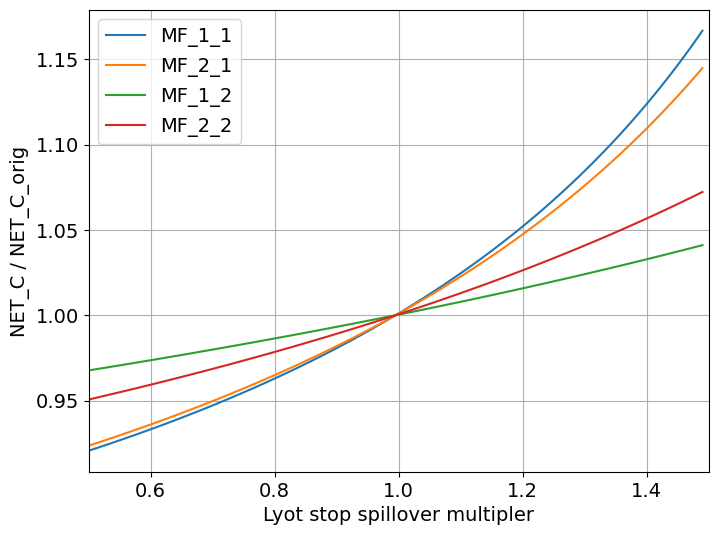

In [31]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [8, 6]

yamlfile = 'yamls/'+'SAT_HWP_aggr_20240916.yaml'

chs = ['MF_1_1', 'MF_2_1', 'MF_1_2', 'MF_2_2']

NETs = {}
for ch in chs:
    NETs[ch] = np.array([])

spill_multipliers = np.arange(0.5,1.5,0.01)
for spill_multiplier in spill_multipliers:  # We can do this because all the values in the yaml file are less than 0.5
    sim = yaml.safe_load(open(yamlfile))

    # set the lyot absorption to a new value.  This is a list, so we have to iterate through it.
    for ii in np.arange(len(sim['optical_elements']['lyot']['absorption'])):
        sim['optical_elements']['lyot']['absorption'][ii] = spill_multiplier*sim['optical_elements']['lyot']['absorption'][ii]

    # Run
    run_optics(sim)
    run_bolos(sim)

    for ch in chs:
        NETs[ch] = np.append(NETs[ch],sim['outputs'][ch]['NET_C_total'])

for ch in chs:
    plt.plot(spill_multipliers,NETs[ch]/np.median(NETs[ch]),label=ch)

plt.xlabel('Lyot stop spillover multipler')
plt.ylabel('NET_C / NET_C_orig')
plt.xlim(0.5,1.5)
plt.legend()
plt.grid()



{'MF_1_1': array([0.00024588, 0.00025372, 0.00026378, 0.00027721, 0.00029612]),
 'MF_2_1': array([0.00022798, 0.00023503, 0.00024382, 0.00025512, 0.00027024]),
 'MF_1_2': array([0.00030641, 0.00031043, 0.00031483, 0.00031967, 0.00032504]),
 'MF_2_2': array([0.00035599, 0.00036312, 0.00037132, 0.00038087, 0.00039215])}

In [13]:
sim['outputs'].keys()

dict_keys(['LF_1', 'LF_2', 'MF_1_1', 'MF_2_1', 'MF_1_2', 'MF_2_2', 'HF_1', 'HF_2'])

# The "max_f145" model above is not correct - I need to calculate the spillover.  It's not the same as the baseline, as the horns are smaller.

# Things below here are not updated, don't count on them.

# NET vs pwv 

Calculate and print NET as f(pwv) to a toml file, 
different toml file for each SAT model.

We want to set Psat to the value designed for (elev0, pwv0), then keep it fixed after that.

In [9]:
writefile = False  # set to true to write output toml files

elev0 = 50 # degrees

# Run cells above first, need to set default Psats.

for model in SAT_models.keys():
    print(model)

    # Set up the sim dictionary correctly given the model we're using
    yamlfile = 'yamls/'+SAT_models[model]['yaml']
    sim = yaml.safe_load(open(yamlfile))
    pwv0 = sim['sources']['atmosphere']['pwv']
    elev0 = sim['sources']['atmosphere']['elevation']
    
    # pwv's we want to calculate for
    pwv_vec = np.arange(0,5000,100)

    # Start setting up the output dictionary
    SAT_models[model]['vary_pwv'] = {}
    SAT_models[model]['vary_pwv']['pwv_vec']=pwv_vec
    SAT_models[model]['vary_pwv']['elevation']=elev0
    for ch in SAT_models[model]['channels']:
        SAT_models[model]['vary_pwv'][ch] = {}
        SAT_models[model]['vary_pwv'][ch]['NET_NC']=np.array([])
        SAT_models[model]['vary_pwv'][ch]['corr_factor']=np.array([])
        SAT_models[model]['vary_pwv'][ch]['NET_wafer']=np.array([])
        SAT_models[model]['vary_pwv'][ch]['NET_tube']=np.array([])
        SAT_models[model]['vary_pwv'][ch]['P_opt'] = np.array([])

    # Run jbolo in a loop to fill in the pwv-dependent variables in that dictionary
    for pwv in pwv_vec:
        
        # Clear previous iteration results so things don't multiply.
        if 'outputs' in sim.keys():  
            sim['outputs'].clear()  

        # Fixed psat, ie same one every time.
        sim['bolo_config']['method']='specified'
        for ch in sim['channels'].keys():
            sim['channels'][ch]['psat'] = SAT_models[model][ch]['P_sat']
        
        # New value of pwv
        sim['sources']['atmosphere']['pwv']=pwv    
        
        # run jbolo
        run_optics(sim)
        run_bolos(sim)

        # save pwv-dependent outputs
        for ch in SAT_models[model]['channels']:
            SAT_models[model]['vary_pwv'][ch]['NET_NC']     =np.append(SAT_models[model]['vary_pwv'][ch]['NET_NC'],     1e6*sim['outputs'][ch]['NET_NC_total'])
            SAT_models[model]['vary_pwv'][ch]['corr_factor']=np.append(SAT_models[model]['vary_pwv'][ch]['corr_factor'],sim['outputs'][ch]['corr_factor' ])

            net1det = 1e6*sim['outputs'][ch]['NET_C_total']  # use the version with horn-horn correlations
            ndet = sim['channels'][ch]['num_det_per_wafer']  # detectors per wafer
            net_wafer = net1det/np.sqrt(ndet*sim['bolo_config']['yield'])  #Take yield into account, usually 80%
            net_tube = net_wafer/np.sqrt(SAT_models[model]['wafers']*SAT_models[model]['optically_good_fraction'])  #Take yield into account, usually 80%
            #ms = 1/net_tube**2
            SAT_models[model]['vary_pwv'][ch]['NET_wafer']=np.append(SAT_models[model]['vary_pwv'][ch]['NET_wafer'],net_wafer)
            SAT_models[model]['vary_pwv'][ch]['NET_tube']= np.append(SAT_models[model]['vary_pwv'][ch]['NET_tube'],net_tube)
            SAT_models[model]['vary_pwv'][ch]['P_opt'] =   np.append(SAT_models[model]['vary_pwv'][ch]['P_opt'],1e12*sim['outputs'][ch]['P_opt'])


    if writefile==True:
        toml_output_file = 'SAT_NET_v_pwv_'+str(model)+'.toml'
        with open(toml_output_file, "w") as toml_file:
            toml.dump(output_dict, toml_file, encoder=toml.TomlNumpyEncoder())


Pole_orig
Pole_max
Chile_AoAAlt3
Chile_max


# Plot NET vs pwv results

In [10]:
SAT_models['Pole_orig']

{'yaml': 'SAT_baseline_20220726.yaml',
 'comment': 'NETs are in uKrtsec; powers are in pW',
 'name': 'S4orig, no HWP',
 'site': 'Pole',
 'pwv': 321,
 'elev': 50,
 'wafers': 12,
 'optically_good_fraction': 0.875,
 'channels': dict_keys(['LF_1', 'LF_2', 'MF_1_1', 'MF_2_1', 'MF_1_2', 'MF_2_2', 'HF_1', 'HF_2']),
 'LF_1': {'P_sat': 1.4350170961175082,
  'NET_wafer': 38.62122729651274,
  'NET_tube': 11.918769502998606,
  'mapping_speed': 0.007039424541700559,
  'NET_C': 169.22973911067436,
  'corr_factor': 1.0321587630335431,
  'NET_NC': 163.95708215788764},
 'LF_2': {'P_sat': 5.812238611371344,
  'NET_wafer': 47.62482084768956,
  'NET_tube': 14.697338796285946,
  'mapping_speed': 0.004629377420873149,
  'NET_C': 208.68150940337506,
  'corr_factor': 1.0112964982383064,
  'NET_NC': 206.35047166375182},
 'MF_1_1': {'P_sat': 7.499538366137135,
  'NET_wafer': 19.514640021502785,
  'NET_tube': 6.022348657244378,
  'mapping_speed': 0.027571996214088654,
  'NET_C': 299.28103915836493,
  'corr_facto

Text(0.1, 60, 'HF_2')

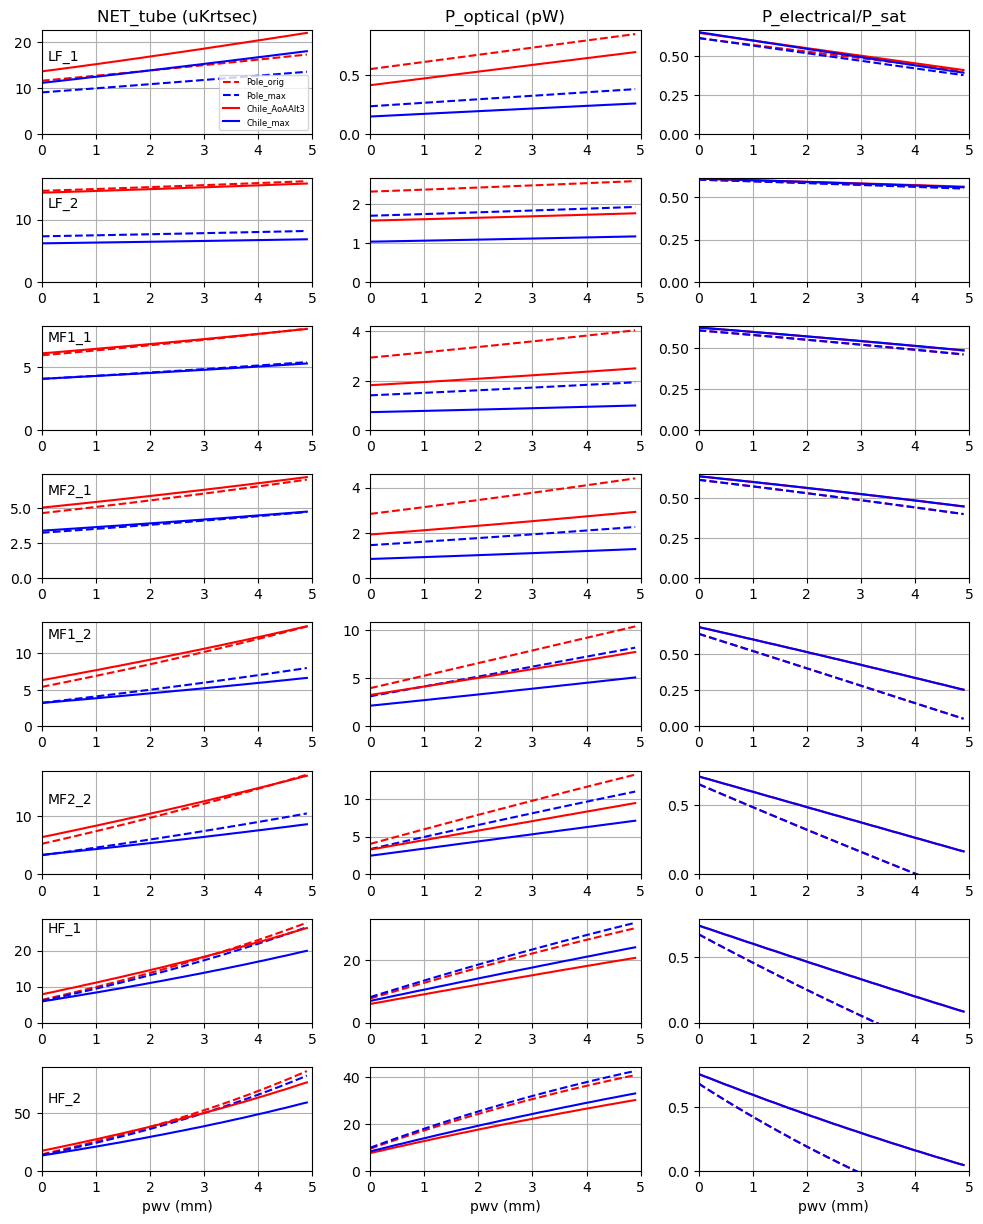

In [11]:
# Run cells above first.

plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [10, 12]

fig,axs = plt.subplots(8,3)  # plot [NET_tube, P_opt, P_sat-P_opt] vs pwv for each of the 8 channels
plt.tight_layout()

lcolor=['r','b','r','b']
ltypes = ['--','--','-','-']

col = 0
mm = 0
for model in SAT_models.keys():
    ii=0
    for ch in SAT_models[model]['channels']:
        axs[ii][col].plot(SAT_models[model]['vary_pwv']['pwv_vec']/1000,SAT_models[model]['vary_pwv'][ch]['NET_tube'], 
                          color = lcolor[mm],
                          linestyle=ltypes[mm], label=model)
        #axs[ii][col].text(0.1,50,ch)
        ii += 1
    mm += 1

col = 1
mm = 0
for model in SAT_models.keys():
    ii=0
    for ch in SAT_models[model]['channels']:
        axs[ii][col].plot(SAT_models[model]['vary_pwv']['pwv_vec']/1000,SAT_models[model]['vary_pwv'][ch]['P_opt'], 
                          color = lcolor[mm],
                          linestyle=ltypes[mm], label=model)
        #axs[ii][col].text(0.1,50,ch)
        ii += 1
    mm += 1

col = 2
mm = 0
for model in SAT_models.keys():
    ii=0
    for ch in SAT_models[model]['channels']:
        P_sat = SAT_models[model][ch]['P_sat']
        P_opt = SAT_models[model]['vary_pwv'][ch]['P_opt']
        P_elec =  P_sat-P_opt
        axs[ii][col].plot(SAT_models[model]['vary_pwv']['pwv_vec']/1000,P_elec/P_sat, 
                          color = lcolor[mm],
                          linestyle=ltypes[mm])
        #axs[ii][col].text(0.1,50,ch)
        ii += 1
    mm += 1
    
for ii in np.arange(8):
#    axs[ii][0].set_ylim(0)
#    axs[ii][0].set_xlim(0,1)
#    axs[ii][1].set_ylim(0)
#    axs[ii][1].set_xlim(0,3)
    for col in [0,1,2]:
        axs[ii][col].grid()
        axs[ii][col].set_xlim(0,5)
        axs[ii][col].set_ylim(0)
        axs[7][col].set_xlabel('pwv (mm)')

axs[0][0].legend(fontsize=6)

axs[0][0].set_title('NET_tube (uKrtsec)')
axs[0][1].set_title('P_optical (pW)')
axs[0][2].set_title('P_electrical/P_sat')
axs[0][0].text(.1,16,'LF_1') 
axs[1][0].text(.1,12,'LF_2') 
axs[2][0].text(.1,7,'MF1_1') 
axs[3][0].text(.1,6,'MF2_1')
axs[4][0].text(.1,12,'MF1_2') 
axs[5][0].text(.1,12,'MF2_2')
axs[6][0].text(.1,25,'HF_1') 
axs[7][0].text(.1,60,'HF_2')

    

    

# NET vs elevation

In [12]:
writefile = False  # set to true to write output toml files

# Run cells above first, need to set default Psats.

# elevations we want to calculate for
elev_vec = np.arange(20,90,1)

for model in SAT_models.keys():
    print(model)

    # Set up the sim dictionary correctly given the model we're using
    yamlfile = 'yamls/'+SAT_models[model]['yaml']
    sim = yaml.safe_load(open(yamlfile))
    pwv0 = sim['sources']['atmosphere']['pwv']
    elev0 = sim['sources']['atmosphere']['elevation']
    
    # Start setting up the output dictionary
    SAT_models[model]['vary_elev'] = {}
    SAT_models[model]['vary_elev']['elev_vec']=elev_vec
    SAT_models[model]['vary_elev']['pwv']=pwv0
    for ch in SAT_models[model]['channels']:
        SAT_models[model]['vary_elev'][ch] = {}
        SAT_models[model]['vary_elev'][ch]['NET_NC']=np.array([])
        SAT_models[model]['vary_elev'][ch]['corr_factor']=np.array([])
        SAT_models[model]['vary_elev'][ch]['NET_wafer']=np.array([])
        SAT_models[model]['vary_elev'][ch]['NET_tube']=np.array([])
        SAT_models[model]['vary_elev'][ch]['P_opt'] = np.array([])

    # Run jbolo in a loop to fill in the pwv-dependent variables in that dictionary
    for elev in elev_vec:
        
        # Clear previous iteration results so things don't multiply.
        if 'outputs' in sim.keys():  
            sim['outputs'].clear()  

        # Fixed psat, ie same one every time.
        sim['bolo_config']['method']='specified'
        for ch in sim['channels'].keys():
            sim['channels'][ch]['psat'] = SAT_models[model][ch]['P_sat']
        
        # New value of pwv
        sim['sources']['atmosphere']['elevation']=elev    
        
        # run jbolo
        run_optics(sim)
        run_bolos(sim)

        # save pwv-dependent outputs
        for ch in SAT_models[model]['channels']:
            SAT_models[model]['vary_elev'][ch]['NET_NC']     =np.append(SAT_models[model]['vary_elev'][ch]['NET_NC'],     1e6*sim['outputs'][ch]['NET_NC_total'])
            SAT_models[model]['vary_elev'][ch]['corr_factor']=np.append(SAT_models[model]['vary_elev'][ch]['corr_factor'],sim['outputs'][ch]['corr_factor' ])

            net1det = 1e6*sim['outputs'][ch]['NET_C_total']  # use the version with horn-horn correlations
            ndet = sim['channels'][ch]['num_det_per_wafer']  # detectors per wafer
            net_wafer = net1det/np.sqrt(ndet*sim['bolo_config']['yield'])  #Take yield into account, usually 80%
            net_tube = net_wafer/np.sqrt(SAT_models[model]['wafers']*SAT_models[model]['optically_good_fraction'])  #Take yield into account, usually 80%
            #ms = 1/net_tube**2
            SAT_models[model]['vary_elev'][ch]['NET_wafer']=np.append(SAT_models[model]['vary_elev'][ch]['NET_wafer'],net_wafer)
            SAT_models[model]['vary_elev'][ch]['NET_tube']= np.append(SAT_models[model]['vary_elev'][ch]['NET_tube'],net_tube)
            SAT_models[model]['vary_elev'][ch]['P_opt'] =   np.append(SAT_models[model]['vary_elev'][ch]['P_opt'],1e12*sim['outputs'][ch]['P_opt'])


    if writefile==True:
        toml_output_file = 'SAT_NET_v_elev_'+str(model)+'.toml'
        with open(toml_output_file, "w") as toml_file:
            toml.dump(output_dict, toml_file, encoder=toml.TomlNumpyEncoder())


Pole_orig
Pole_max
Chile_AoAAlt3
Chile_max


# Plot NET vs elevation
(and Poptical, Pelectrical/Psat)

Text(0.1, 60, 'HF_2')

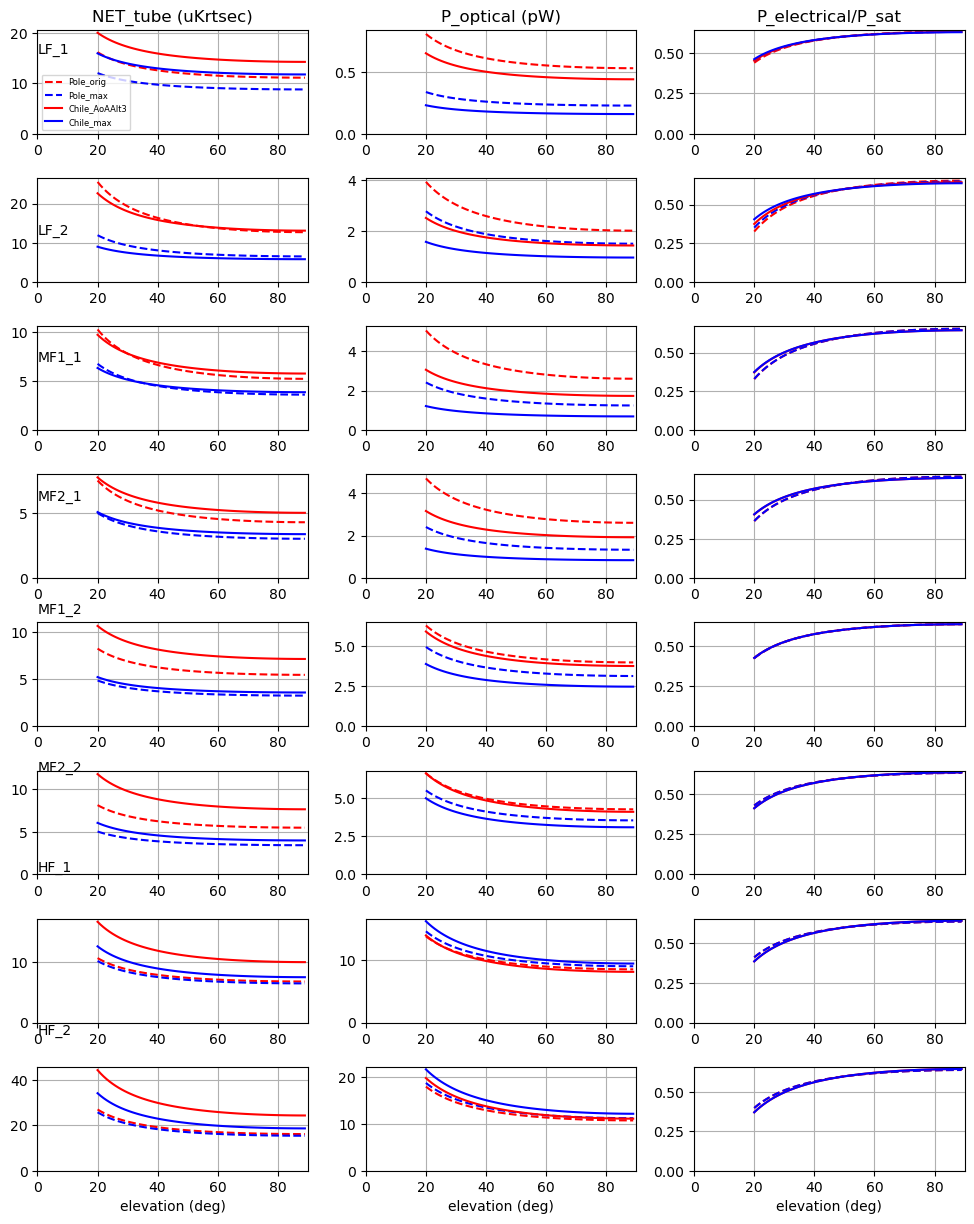

In [13]:
# Run cells above first.

plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [10, 12]

fig,axs = plt.subplots(8,3)  # plot [NET_tube, P_opt, P_sat-P_opt] vs pwv for each of the 8 channels
plt.tight_layout()

lcolor=['r','b','r','b']
ltypes = ['--','--','-','-']

col = 0
mm = 0
for model in SAT_models.keys():
    ii=0
    for ch in SAT_models[model]['channels']:
        axs[ii][col].plot(SAT_models[model]['vary_elev']['elev_vec'],SAT_models[model]['vary_elev'][ch]['NET_tube'], 
                          color = lcolor[mm],
                          linestyle=ltypes[mm], label=model)
        #axs[ii][col].text(0.1,50,ch)
        ii += 1
    mm += 1

col = 1
mm = 0
for model in SAT_models.keys():
    ii=0
    for ch in SAT_models[model]['channels']:
        axs[ii][col].plot(SAT_models[model]['vary_elev']['elev_vec'],SAT_models[model]['vary_elev'][ch]['P_opt'], 
                          color = lcolor[mm],
                          linestyle=ltypes[mm], label=model)
        #axs[ii][col].text(0.1,50,ch)
        ii += 1
    mm += 1

col = 2
mm = 0
for model in SAT_models.keys():
    ii=0
    for ch in SAT_models[model]['channels']:
        P_sat = SAT_models[model][ch]['P_sat']
        P_opt = SAT_models[model]['vary_elev'][ch]['P_opt']
        P_elec =  P_sat-P_opt
        axs[ii][col].plot(SAT_models[model]['vary_elev']['elev_vec'],P_elec/P_sat, 
                          color = lcolor[mm],
                          linestyle=ltypes[mm])
        #axs[ii][col].text(0.1,50,ch)
        ii += 1
    mm += 1
    
for ii in np.arange(8):
#    axs[ii][0].set_ylim(0)
#    axs[ii][0].set_xlim(0,1)
#    axs[ii][1].set_ylim(0)
#    axs[ii][1].set_xlim(0,3)
    for col in [0,1,2]:
        axs[ii][col].grid()
        axs[ii][col].set_xlim(0,90)
        axs[ii][col].set_ylim(0)
        axs[7][col].set_xlabel('elevation (deg)')

axs[0][0].legend(fontsize=6)

axs[0][0].set_title('NET_tube (uKrtsec)')
axs[0][1].set_title('P_optical (pW)')
axs[0][2].set_title('P_electrical/P_sat')
axs[0][0].text(.1,16,'LF_1') 
axs[1][0].text(.1,12,'LF_2') 
axs[2][0].text(.1,7,'MF1_1') 
axs[3][0].text(.1,6,'MF2_1')
axs[4][0].text(.1,12,'MF1_2') 
axs[5][0].text(.1,12,'MF2_2')
axs[6][0].text(.1,25,'HF_1') 
axs[7][0].text(.1,60,'HF_2')


# Write toml file with all of the results so far.

If all of the cells above have been run, the SAT_models dictionary includes:
- default (el,pwv) values
- vectors of things vs pwv
- vectors of things vs elevation

In [14]:
toml_output_file = 'SAT_models_outputs_20240619.toml'
with open(toml_output_file, "w") as toml_file:
    toml.dump(SAT_models, toml_file, encoder=toml.TomlNumpyEncoder())

In [16]:
!ls -lh

total 1960
lrwxr-xr-x  1 ruhl  staff    20B Jun 18 11:51 ApertureFuncs -> ../../ApertureFuncs/
-rw-r--r--  1 ruhl  staff   582K Jun 19 13:10 SAT_NETs_Chile.ipynb
-rw-r--r--  1 ruhl  staff   8.3K Jun 19 13:07 SAT_models_output_20240618.toml
-rw-r--r--  1 ruhl  staff   383K Jun 19 13:10 SAT_models_outputs_20240619.toml
lrwxr-xr-x  1 ruhl  staff    11B Jun 18 11:51 atmos -> ../../atmos
drwxr-xr-x  7 ruhl  staff   224B Jun 18 16:10 yamls


# Print a table with relevant mapping speed ratios
- (Pole_max/Pole_baseline)
- (Chile_max/ChileAoAscaledoptics)

In [24]:
writetofile = True

if writetofile:
    outfile = open('mapping_speed_ratios.txt', 'w')
else:
    outfile = sys.stdout

print('# Mapping speed ratios', file=outfile)
print('# Channel  Pole_max/Pole_orig  Chile_max/Chile_AoAscaledoptics',file=outfile)   
for ch in SAT_models['Pole_orig']['channels']:
    ms0 = 1/SAT_models['Pole_orig'][ch]['NET_tube']**2
    ms1 = 1/SAT_models['Pole_max'][ch]['NET_tube']**2
    rpole = ms1/ms0
    ms2 = 1/SAT_models['Chile_AoAAlt3'][ch]['NET_tube']**2
    ms3 = 1/SAT_models['Chile_max'][ch]['NET_tube']**2
    rchile = ms3/ms2
    #
    print(f'{ch.ljust(7)} {rpole:12.2f} {rchile:15.2f}',file=outfile)

if writetofile:
    outfile.close()

In [25]:
!ls -l

total 1952
lrwxr-xr-x  1 ruhl  staff      20 Jun 18 11:51 ApertureFuncs -> ../../ApertureFuncs/
-rw-r--r--  1 ruhl  staff  598987 Jun 19 14:27 SAT_NETs_Chile.ipynb
-rw-r--r--  1 ruhl  staff  392054 Jun 19 13:10 SAT_models_outputs_20240619.toml
lrwxr-xr-x  1 ruhl  staff      11 Jun 18 11:51 atmos -> ../../atmos
-rw-r--r--  1 ruhl  staff     382 Jun 19 14:29 mapping_speed_ratios.txt
drwxr-xr-x  7 ruhl  staff     224 Jun 18 16:10 yamls
